In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import celerite as celery
import exoplanet as xo
np.random.seed(42)
%matplotlib inline

data_dir = '/Users/mbedell/python/pmodes/experiments/data/'

import utils

In [2]:
import pymc3 as pm
import theano.tensor as tt
import theano
from exoplanet.gp import terms, GP

theano.config.gcc.cxxflags = "-Wno-c++11-narrowing" # thx dfm

In [3]:
xlim_data = np.array([10.2, 10.8]) * 86400 # for selecting all data
xlim_plot = [890000, 895000] # for zoomed-in plots

#### single-mode fit:

In [4]:
d = np.genfromtxt(data_dir+'sim_oneyear_onemode.csv', names=True, dtype=None, delimiter=',')
ts_onemode = np.copy(d['ts'])
rvs_onemode = np.copy(d['rvs'])
xs_onemode = np.copy(d['xs'])

In [11]:
inds = (ts_onemode > 10.49 * 86400) & (ts_onemode < 10.51 * 86400)
t = ts_onemode[inds]
y = rvs_onemode[inds]
yerr = np.zeros_like(y) + 0.01 # 1 cm/s homogeneous error - made up!
t_grid = np.linspace(t[0], t[-1], 1000)

In [15]:
log_S0 = -6.7
log_Q = 8.7
log_omega0 = -3.9255768

with pm.Model() as model:
    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=log_S0, log_w0=log_omega0, log_Q=log_Q)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

    #map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True))
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t))

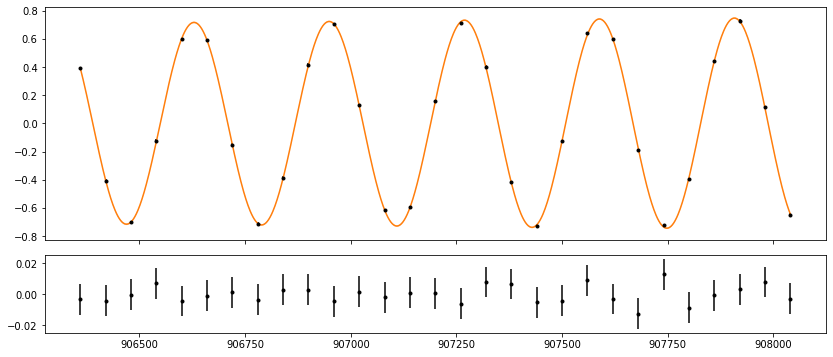

In [16]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})
ax1.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")

# Plot the prediction and the 1-sigma uncertainty
art = ax1.fill_between(t_grid, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_grid, mu, color="C1", label="prediction")

ax2.errorbar(t, y - y_pred, yerr=yerr, fmt=".k", capsize=0, label="resids");

#### multi-mode RVs fit as single mode:

In [17]:
d = np.genfromtxt(data_dir+'sim_oneyear.csv', names=True, dtype=None, delimiter=',')
ts_multimode = np.copy(d['ts'])
rvs_multimode = np.copy(d['rvs'])
xs_multimode = np.copy(d['xs'])

In [18]:
inds = (ts_multimode > xlim_data[0]) & (ts_multimode < xlim_data[1])
t_all = ts_multimode[inds]
y_all = rvs_multimode[inds]
yerr_all = np.zeros_like(y_all) + 0.01 # 1 cm/s homogeneous error - made up!

In [19]:
inds = np.random.choice(np.arange(len(t_all)), size=200, replace=False)
inds.sort()
t = t_all[inds]
y = y_all[inds]
yerr = np.zeros_like(y) + 0.01 # 1 cm/s homogeneous error - made up!
t_grid = np.linspace(t[0], t[-1], 1000)

In [23]:
log_S0 = 0.7
log_Q = 3.5
log_omega0 = -3.9

with pm.Model() as model:

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=log_S0, log_w0=log_omega0, log_Q=log_Q)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True))
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t))
    y_pred_all = xo.eval_in_model(gp.predict(t_all))

Text(0.5, 0.93, 'exposure time = 1 minute; non-integrated single-mode GP model')

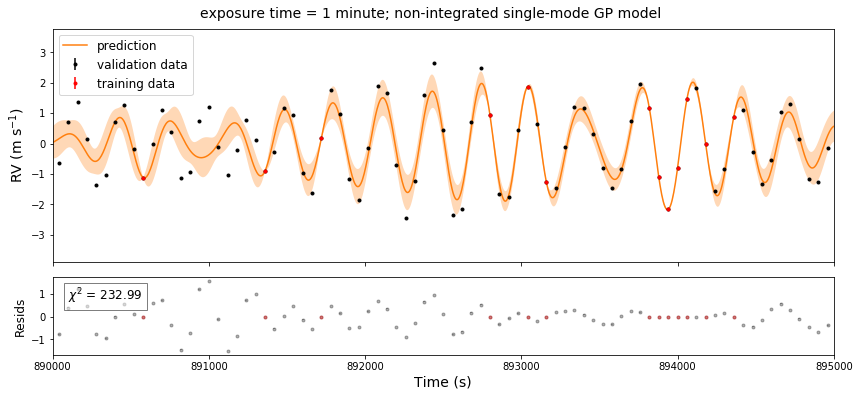

In [24]:
fig = utils.plot_validation_test(t, y, yerr, y_pred, t_all, y_all, yerr_all, y_pred_all, t_grid, mu, sd)
fig.suptitle('exposure time = 1 minute; non-integrated single-mode GP model', y=0.93, fontsize=14);
#fig.savefig('GPvalidation_1min.png');

### Longer-integration observations

Now that we're satisfied the GP works in general, let's test how it performs for observations that are integrated over longer times.

In [27]:
inds = (ts_multimode > xlim_data[0]) & (ts_multimode < xlim_data[1])
exp_time = 5. * 60. #seconds
start_ts = ts_multimode[inds]
mid_rvs = np.array([utils.simulate_exposure(ts_multimode, rvs_multimode, tt, exp_time) for tt in start_ts])
mid_ts = start_ts + exp_time/2.

In [28]:
t_all = mid_ts
y_all = mid_rvs
yerr_all = np.zeros_like(y_all) + 0.01 # 1 cm/s homogeneous error - made up!

inds = np.random.choice(np.arange(len(t_all)), size=200, replace=False)
inds.sort()
t = mid_ts[inds]
y = mid_rvs[inds]
yerr = yerr_all[inds]
t_grid = np.linspace(xlim_plot[0], xlim_plot[1], 1000)

#### integrated exposures modeled with single-SHO kernel non-integrated GP:

In [29]:
log_S0 = 0.7
log_Q = 3.5
log_omega0 = -3.9

with pm.Model() as model:

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=log_S0, log_w0=log_omega0, log_Q=log_Q)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True))
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t))
    y_pred_all = xo.eval_in_model(gp.predict(t_all))

Text(0.5, 0.93, 'exposure time = 5 minutes; non-integrated single-mode GP model')

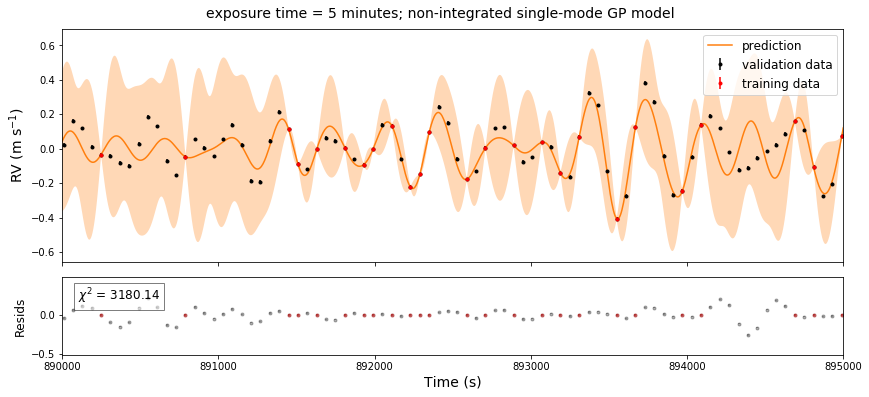

In [30]:
fig = utils.plot_validation_test(t, y, yerr, y_pred, t_all, y_all, yerr_all, y_pred_all, t_grid, mu, sd)
fig.suptitle('exposure time = {0:.0f} minutes; non-integrated single-mode GP model'.format(exp_time/60.), 
             y=0.93, fontsize=14);
#fig.savefig('GPvalidation_{0:.0f}min_nonintegrated.png'.format(exp_time/60.));

#### integrated exposures modeled with single-SHO kernel integrated GP:

In [33]:
with pm.Model() as model:

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=log_S0, log_w0=log_omega0, log_Q=log_Q)
    kernel_int = terms.IntegratedTerm(kernel, exp_time)
    gp = GP(kernel_int, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True))
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t))
    y_pred_all = xo.eval_in_model(gp.predict(t_all))

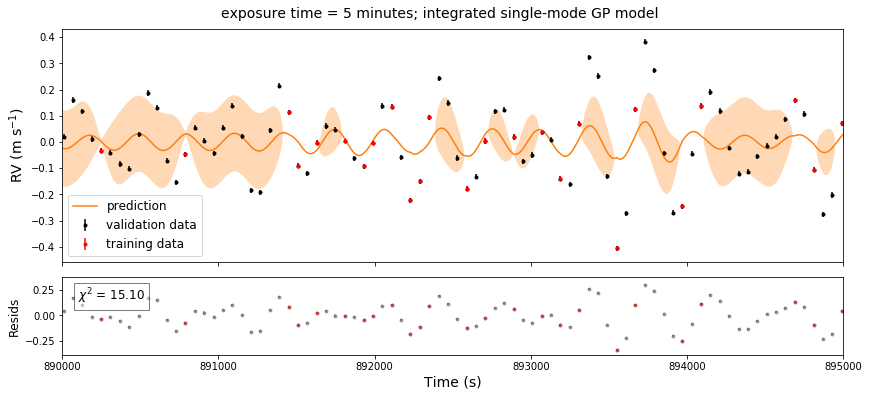

In [35]:
fig = utils.plot_validation_test(t, y, yerr, y_pred, t_all, y_all, yerr_all, y_pred_all, t_grid, mu, sd)
fig.suptitle('exposure time = {0:.0f} minutes; integrated single-mode GP model'.format(exp_time/60.), 
             y=0.93, fontsize=14);
#fig.savefig('GPvalidation_{0:.0f}min_integrated.png'.format(exp_time/60.));

take an optimal exposure nightly vs. take multiple short exposures every few nights
gp hyperpar omega vs rv rms
if you get your optimal exposure time wrong and coherence time is ~days then you have correlated noise